# Neural network for segmenting LV of heart

## Introduction
This work was performed as part of the MRAI workshop (MIDL 2019 satellite meeting) with exercises designed by Esther Puyol (https://github.com/estherpuyol/MRAI_workshop).

### Background
Quantitative analysis of cardiac MRI images typically requires a segmentation of the left ventricular (LV) myocardium from the surrounding tissues and  blood pool. This segmentation allows for calculations of useful clinical metrics such as LV ejection fraction, stroke fraction and myocardial mass. However, this segmentation process is often performed manually making it time consuming and susceptible to operator dependent variablility.

### Objective
Train a neural network to automatically segment the left ventricle from 2D short axis cardiac MR images.

## Import modules
The network is built using functions and classes from the [TensorFlow toolkit](https://www.tensorflow.org/)

In [0]:
import os
import numpy as np
import pylab as plt
import tensorflow as tf

## Download dataset
The data for this study is from the [Sunnybrook Cardiac Data](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/)

A preprocessed subset of this data is used, where the data is filtered to contain only left ventricle myocardium segmentations and reduced in XY dimensions.

In [3]:
![ -f scd_lvsegs.npz ] || wget https://github.com/estherpuyol/MRAI_workshop/raw/master/scd_lvsegs.npz

data = np.load('scd_lvsegs.npz') # load all the data from the archive

images = data['images'] # images in BHW array order : .shape (420, 64, 64)]
segs = data['segs'] # segmentations in BHW array order : .shape (420, 64, 64)
caseIndices = data['caseIndices'] # the indices in `images` for each case : .shape (45, 2)

images = images.astype(np.float32)/images.max() # normalize images

--2019-09-09 10:58:05--  https://github.com/estherpuyol/MRAI_workshop/raw/master/scd_lvsegs.npz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/estherpuyol/MRAI_workshop/master/scd_lvsegs.npz [following]
--2019-09-09 10:58:06--  https://raw.githubusercontent.com/estherpuyol/MRAI_workshop/master/scd_lvsegs.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2133403 (2.0M) [application/octet-stream]
Saving to: ‘scd_lvsegs.npz’

scd_lvsegs.npz      100%[===================>]   2.03M  --.-KB/s    in 0.05s   

2019-09-09 10:58:06 (39.5 MB/s) - ‘scd_lvsegs.npz’ saved [2133403/2133403]



## Split training and test data
Here we split the dataset into seperate training and test blocks where the variable ```test_fraction``` determines the proportion of the splt between cases.

In [0]:
test_fraction = 0.1
n_testing = int(test_fraction * caseIndices.shape[0])

testIndex = caseIndices[-n_testing,0] # keep the last n_training cases for testing

# divide the images, segmentations, and categories into train/test sets
trainImages,trainSegs = images[:testIndex],segs[:testIndex]
testImages,testSegs = images[testIndex:],segs[testIndex:]

## Define segmentation network
I have chosen to implement a Unet style network for segmenting the left ventricle these networks perform well in image classification problems for several reasons:
* Firstly, the U-net style architecture works well for pixel-wise classification tasks 
* The contraction/expansion paths combines high and low level image features.
* Finally, U-net style architectures perform well even with relatively small numbers of training examples (several hundered is acceptable)


In [0]:
class Unet(tf.keras.Model):
    def __init__(self, input_shape, conv_channels, kernels=[3], strides=[2], training=True, verbose=False):
        super().__init__()

        self._conv_channels = conv_channels
        self._kernels = kernels
        self._strides = strides

        # check kernel, strides and substack size are equal and make them equal if only a single kernel size is used
        if (len(conv_channels) is not len(kernels)):
            if len(kernels) is 1:
                self._kernels = [item for item in self._kernels for i in range(len(self._conv_channels))]
            else:
                raise AssertionError('conv_channels and kernel lists must have equal length')
        
        if (len(conv_channels) is not len(self._strides)):
            if len(self._strides) is 1:
                self._strides = [item for item in self._strides for i in range(len(self._conv_channels))]
            else:
                raise AssertionError('conv_channels and strides lists must have equal length')

        self._encoder = []

        # define input
        input_tensor = tf.keras.Input(shape=input_shape)

        # first layer
        n = 0
        C_out = self._conv_channels[0]
        self._enc = tf.keras.layers.Conv2D(C_out, 
                                           self._kernels[n], 
                                           strides=self._strides[n], 
                                           padding='same', 
                                           data_format='channels_first')(input_tensor)
                                           
        self._enc = tf.keras.layers.LayerNormalization(axis=1)(self._enc)
        self._enc = tf.keras.layers.Dropout(0.15)(self._enc)
        self._enc = tf.keras.layers.PReLU()(self._enc)
        self._encoder.append(self._enc)

        # Contraction pathway
        for n, C_out in enumerate(self._conv_channels[1:]):
            self._enc = tf.keras.layers.Conv2D(C_out, 
                                               self._kernels[n], 
                                               strides=self._strides[n], 
                                               padding='same', 
                                               data_format='channels_first')(self._enc)

            self._enc = tf.keras.layers.BatchNormalization(axis=1)(self._enc)
            self._enc = tf.keras.layers.Dropout(0.15)(self._enc)
            self._enc = tf.keras.layers.PReLU()(self._enc)
            self._encoder.append(self._enc)
        
        # reverse lists for transposed convolutions
        self._conv_channels = self._conv_channels[::-1][1:]
        self._kernels = self._kernels[::-1][1:]
        self._strides = self._strides[::-1][1:]

        # Expansion pathway
        self._dec = self._enc
        for n, C_in in enumerate(self._conv_channels):
            self._dec = tf.keras.layers.Conv2DTranspose(C_in, 
                                                        self._kernels[n], 
                                                        strides=self._strides[n], 
                                                        padding='same', 
                                                        data_format='channels_first')(self._dec)

            self._dec = tf.keras.layers.BatchNormalization(axis=1)(self._dec)
            self._dec = tf.keras.layers.Dropout(0.15)(self._dec)
            self._dec = tf.keras.layers.PReLU()(self._dec)
            self._dec = tf.concat([self._dec, self._encoder[len(self._conv_channels) - n - 1]], axis=1)
        
        # Output layer
        output_tensor = tf.keras.layers.Conv2DTranspose(1, 
                                                        self._kernels[n], 
                                                        strides=self._strides[n], 
                                                        padding='same', 
                                                        data_format='channels_first')(self._dec)
        
        # Define model object
        self.model = tf.keras.Model(inputs=[input_tensor], outputs=[output_tensor])
        
        if verbose:
            print(self.model.summary())

    def call(self, x):
        return self.model(x)

## Train network
Now we have defined the U-net model we are ready to fit the network weights to the trainin data. We start by defining number of image channels and convolution kernels for each U-net layer then define the model optimiser and loss functions. 

In this case the Adam optimizer was chosen for its versatility and binary cross entropy chosen for a loss function. Precision was chosen over accuracy as the loss metric since this is less susceptible to class imbalance effects. 

In [25]:
# store the training data as tensors
trainTensor = tf.convert_to_tensor(trainImages[:,None].astype(np.float32))
segTensor = tf.convert_to_tensor(trainSegs[:,None].astype(np.float32))

testsegTensor = tf.convert_to_tensor(testImages[:,None].astype(np.float32))
testimTensor = tf.convert_to_tensor(testSegs[:,None].astype(np.float32))

# create network object
channels= [4, 8, 16, 32, 64]
kernels = [5, 3, 3, 3, 3]

net = Unet([1, 64, 64], channels, kernels=kernels)

# choose a device and  (remember to set Google Colab environment runtime to use GPU)
tf.device("/device:GPU:0")

# define optimizer and loss function
opt = tf.keras.optimizers.Adam(learning_rate=0.005)

net.compile(opt,loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Precision()])
epochs = 32
batch_size = 16
steps = (epochs * int(trainTensor.shape[0]))/batch_size

History = net.fit(trainImages[:, np.newaxis, :, :], 
                  trainSegs[:, np.newaxis, :, :], 
                  batch_size=batch_size, 
                  epochs=epochs, 
                  steps_per_epoch=steps, 
                  shuffle=True, 
                  verbose=2)


Epoch 1/32
774/774 - 42s - loss: 0.0992 - precision_3: 0.6414
Epoch 2/32
774/774 - 40s - loss: 0.0616 - precision_3: 0.7210
Epoch 3/32
774/774 - 40s - loss: 0.0557 - precision_3: 0.7384
Epoch 4/32
774/774 - 40s - loss: 0.0508 - precision_3: 0.7530
Epoch 5/32
774/774 - 40s - loss: 0.0485 - precision_3: 0.7644
Epoch 6/32
774/774 - 40s - loss: 0.0532 - precision_3: 0.7477
Epoch 7/32
774/774 - 40s - loss: 0.0515 - precision_3: 0.7599
Epoch 8/32
774/774 - 40s - loss: 0.0518 - precision_3: 0.7500
Epoch 9/32
774/774 - 40s - loss: 0.0459 - precision_3: 0.7729
Epoch 10/32
774/774 - 40s - loss: 0.0454 - precision_3: 0.7760
Epoch 11/32
774/774 - 40s - loss: 0.0465 - precision_3: 0.7702
Epoch 12/32
774/774 - 40s - loss: 0.0546 - precision_3: 0.7394
Epoch 13/32
774/774 - 40s - loss: 0.0544 - precision_3: 0.7365
Epoch 14/32
774/774 - 40s - loss: 0.0488 - precision_3: 0.7595
Epoch 15/32
774/774 - 40s - loss: 0.0460 - precision_3: 0.7692
Epoch 16/32
774/774 - 40s - loss: 0.0484 - precision_3: 0.7576
E

## Visualise model predictions from training data
The fitted model can now be checked visually by selecting a random sample from the training data and comparing the ground truth to the model estimate. Since the model has seen this data before this is not an indication that the model is able to effectively estimate segmentations from unseen data (this is covered in the next code block).  

Showing results from sample: 140


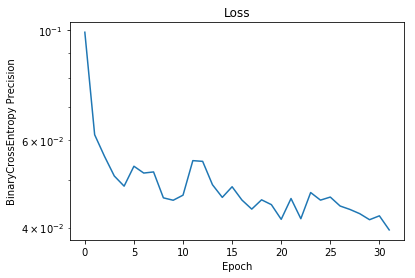

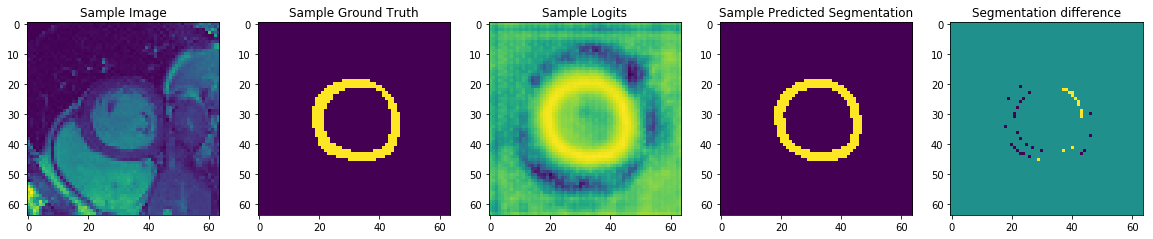

In [31]:
# predict training data
pred = net.predict(trainImages[:, np.newaxis,:,:])

# select random sample (training data)
sample = np.random.randint(0, trainTensor.shape[0]-1)
print('Showing results from sample: %d' % sample)
predSample=np.squeeze(pred[sample,:])
    
# plot training performance
fig,ax=plt.subplots(1,1)
ax.set_title('Loss')
ax.semilogy(History.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('BinaryCrossEntropy Precision')

# plot true segmentation, predicition and difference for training data
fig,ax=plt.subplots(1,5,figsize=(20,4))
ax[0].set_title('Sample Image')
ax[0].imshow(trainImages[sample])
ax[1].set_title('Sample Ground Truth')
ax[1].imshow(trainSegs[sample])
ax[2].set_title('Sample Logits')
ax[2].imshow(predSample)
ax[3].set_title('Sample Predicted Segmentation')
ax[3].imshow(predSample>0.5)
ax[4].set_title('Segmentation difference')
ax[4].imshow((predSample>0.5)-trainSegs[sample])

## Test model on unseen data
Now that the model has been trained its time to test it on the unseen dataset. This code block fits the model to the training data and selects a random sample to display. 

displaying results from test image 11


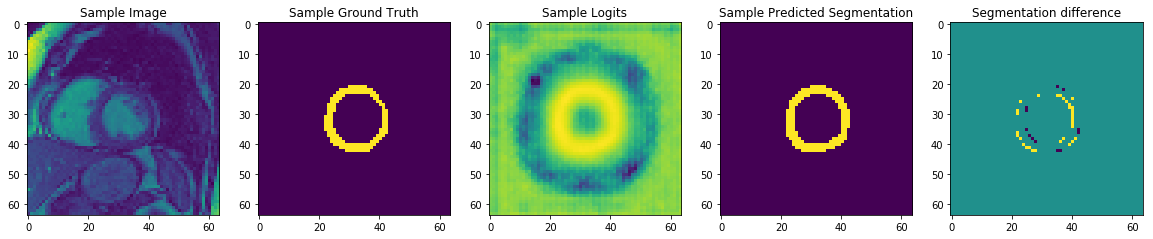

In [27]:
# prediction from test data
pred_test = net.predict(testImages[:,np.newaxis,:,:])
pred_test.shape

# select random sample (test data)
sample = np.random.randint(0, testImages.shape[0])
print('displaying results from test image %s' % sample)
predSample = pred_test[sample,0,:,:]

# plot true segmentation, predicition and difference for test data
fig,ax=plt.subplots(1,5,figsize=(20,5))
ax[0].set_title('Sample Image')
ax[0].imshow(testImages[sample])
ax[1].set_title('Sample Ground Truth')
ax[1].imshow(testSegs[sample])
ax[2].set_title('Sample Logits')
ax[2].imshow(predSample)
ax[3].set_title('Sample Predicted Segmentation')
ax[3].imshow(predSample>0.5)
ax[4].set_title('Segmentation difference')
ax[4].imshow((predSample>0.5)-testSegs[sample])

## Conclusion
The U-net seems to work pretty well!

Limitations?